In [13]:
from pandas import read_csv, DataFrame, concat
from matplotlib import pyplot
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

### Check for autocorrelation

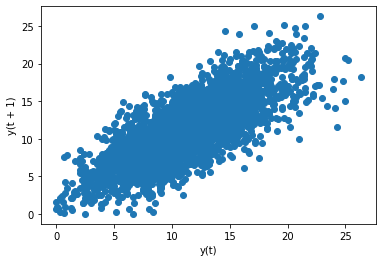

In [4]:
series = read_csv('datasets/daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
lag_plot(series)

In [6]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.77487
t+1  0.77487  1.00000


Shows a strong positive correlation (0.77) between the observation and lag=1 value.

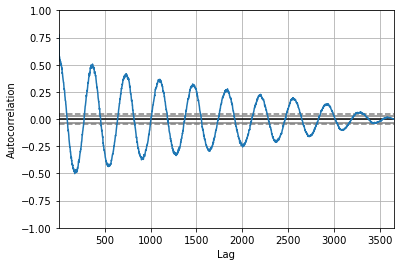

In [8]:
autocorrelation_plot(series)
pyplot.show()

Shows swing in positive and negative correlation as the temperature values change across summer and winter seasons each previous year.

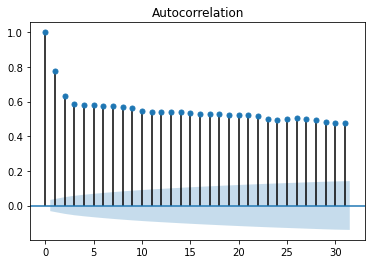

In [10]:
plot_acf(series, lags=31)
pyplot.show()

### Establish baseline performance

In [14]:
X = dataframe.values
train, test = X[1:len(X) - 7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

Test RMSE: 1.850


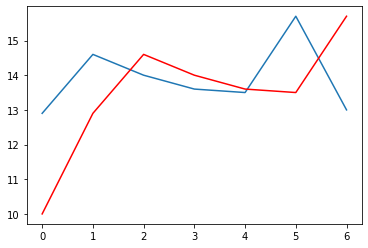

In [15]:
def model_persistence(x):
    return x

predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Using a walkforward validaiton model makes 7 1-day forecasts

### Autoregression Model

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


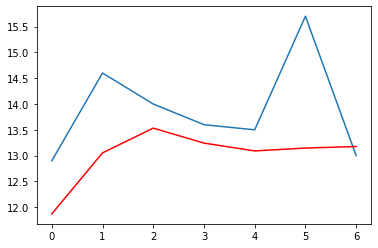

In [17]:
X = series.values
train, test = X[1:len(X) - 7], X[len(X)-7:]

model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
    
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

This creates a 1 7-day forecast which is different from the persistence model above. Looks pretty good with big deviation on day 5. Statsmodels API does not make it easy to update the model as new observations become available. It might be computationally expensive to retrain the model each day. An alternative is to use the learned coefficients and manually make predictions. 

### Manual predictions

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


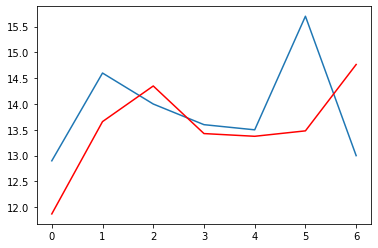

In [18]:
X = series.values
train, test = X[1:len(X) - 7], X[len(X)-7:]

window = 29
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params

history =  train[len(train)- window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
    
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Small improvement in forecast when comparing RMSE scores.